In [1]:
import tensorflow as tf
import os

train_path = "/kaggle/input/stl10/unlabeled_images"
test_path = "/kaggle/input/stl10/test_images"

IMG_SIZE = (96, 96)
BATCH_SIZE = 32
SEED = 42

def process_image(file_path):
    # Leer imagen
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    
    gray = tf.image.rgb_to_grayscale(img)
    return gray, img  

train_files = tf.data.Dataset.list_files(os.path.join(train_path, "*.png"), seed=SEED)
test_files = tf.data.Dataset.list_files(os.path.join(test_path, "*.png"), seed=SEED)

train_dataset = train_files.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(100000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = test_files.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for gray, color in train_dataset.take(1):
    print("Input grayscale:", gray.shape)
    print("Target color:", color.shape)

2025-12-04 13:23:02.075575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764854582.255930      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764854582.303799      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1764854596.840290      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Input grayscale: (32, 96, 96, 1)
Target color: (32, 96, 96, 3)


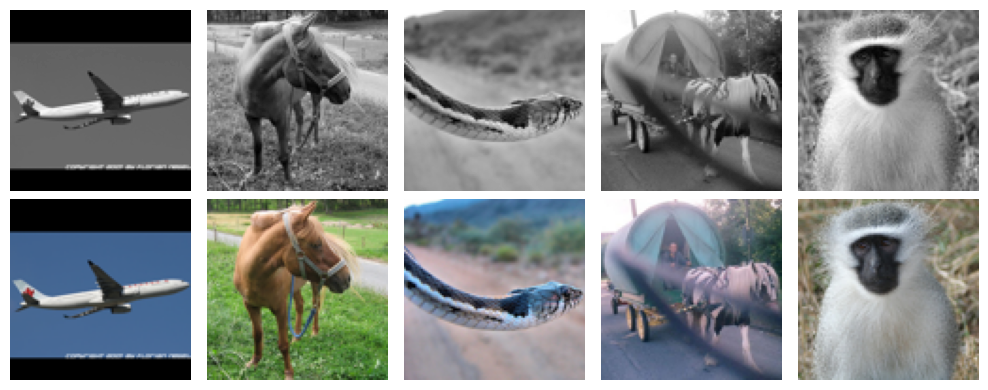

In [2]:
import matplotlib.pyplot as plt

def mostrar_pares_grid(dataset, n=5):
    for gray_batch, color_batch in dataset.take(1):
        plt.figure(figsize=(n*2, 4))
        for i in range(n):
            gray = gray_batch[i].numpy().squeeze()
            color = color_batch[i].numpy()  

            plt.subplot(2, n, i+1)
            plt.imshow(gray, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.ylabel("Gris")

            plt.subplot(2, n, n+i+1)
            plt.imshow(color)
            plt.axis('off')
            if i == 0:
                plt.ylabel("Color")
        
        plt.tight_layout()
        plt.show()

mostrar_pares_grid(train_dataset, n=5)

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import mixed_precision
from tqdm.keras import TqdmCallback

# ============================
# ACTIVAR MIXED PRECISION
# ============================
mixed_precision.set_global_policy('mixed_float16')

print("Precision:", mixed_precision.global_policy())

# ============================
# Bloque residual
# ============================
def residual_block(x, filters, kernel_size=3):
    res = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    if res.shape[-1] != filters:
        res = layers.Conv2D(filters, 1, padding='same')(res)

    x = layers.Add()([x, res])
    x = layers.Activation('relu')(x)
    return x

# ============================
# Autoencoder
# ============================
def autoencoder(input_shape=(96,96,1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x1 = residual_block(x, 64)
    p1 = layers.MaxPooling2D((2,2))(x1)

    x2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2,2))(x2)

    x3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D((2,2))(x3)

    # Bottleneck
    b = residual_block(p3, 512)

    # Decoder
    u3 = layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu')(b)
    x = layers.Concatenate()([u3, x3])
    x = residual_block(x, 256)

    u2 = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.Concatenate()([u2, x2])
    x = residual_block(x, 128)

    u1 = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.Concatenate()([u1, x1])
    x = residual_block(x, 64)

    # Output: ¡IMPORTANTE! → force float32 para evitar problemas con sigmoid en float16
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    return model

# ============================
# Crear y compilar
# ============================
autoencoder = autoencoder(input_shape=(96,96,1))

# Adam automáticamente se envuelve con LossScaleOptimizer en mixed precision
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

autoencoder.compile(optimizer=optimizer, loss='mse')

# ============================
# Entrenamiento
# ============================
autoencoder.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

Precision: <DTypePolicy "mixed_float16">


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1764854794.093491     104 service.cc:148] XLA service 0x78cd8c003870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764854794.094520     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764854796.060501     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764854820.812178     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
# Guardar modelo completo
import keras
keras.saving.save_model(autoencoder, 'autoencoder.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


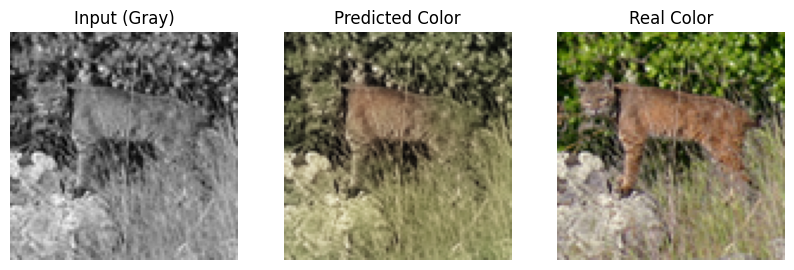

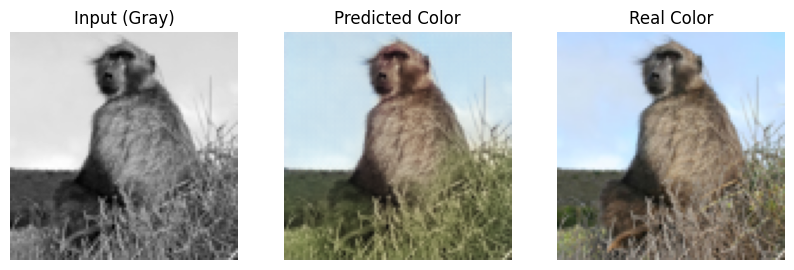

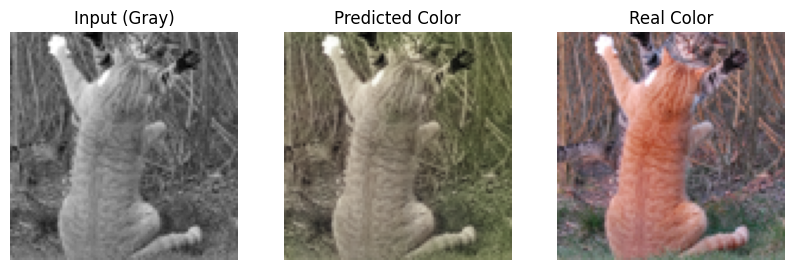

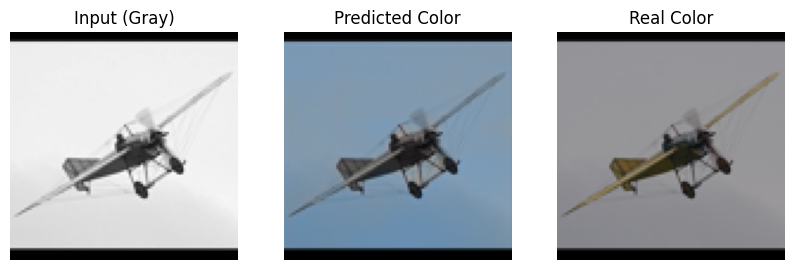

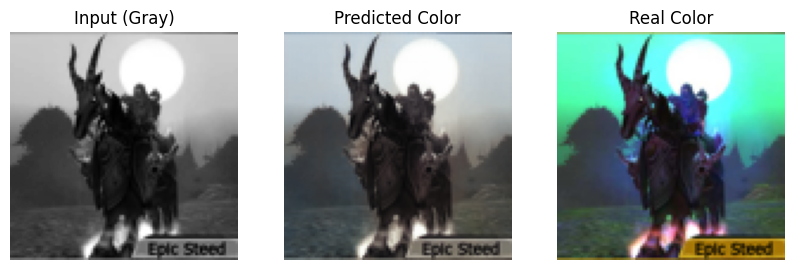

In [3]:
# Tomar un batch del test_dataset
for gray_batch, color_batch in test_dataset.take(1):
    gray_input = gray_batch  # (BATCH, 96, 96, 1)
    true_color = color_batch  # (BATCH, 96, 96, 3)
    break

# Hacer predicción
predicted = autoencoder.predict(gray_input)
import matplotlib.pyplot as plt

def show_result(i):
    plt.figure(figsize=(10,3))

    # Imagen de entrada (grayscale)
    plt.subplot(1,3,1)
    plt.imshow(gray_input[i].numpy().squeeze(), cmap="gray")
    plt.title("Input (Gray)")
    plt.axis("off")

    # Predicción del modelo
    plt.subplot(1,3,2)
    plt.imshow(predicted[i])
    plt.title("Predicted Color")
    plt.axis("off")

    # Imagen real
    plt.subplot(1,3,3)
    plt.imshow(true_color[i])
    plt.title("Real Color")
    plt.axis("off")

    plt.show()

# Mostrar los primeros 5 resultados
for i in range(5):
    show_result(i)


In [ ]:
# Cargar después
from tensorflow.keras.models import load_model
autoencoder_loaded = load_model("autoencoder_colorization.h5", compile=True)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

LATENT_DIM = 256

# ------------------ Encoder ------------------
def build_encoder(input_shape=(96,96,1), latent_dim=LATENT_DIM):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    # Reparameterization trick compatible con mixed precision
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean), dtype=z_mean.dtype)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = layers.Lambda(
        sampling,
        output_shape=(latent_dim,)
    )([z_mean, z_log_var])
    
    return models.Model(inputs, [z, z_mean, z_log_var], name="encoder")

# ------------------ Decoder ------------------
def build_decoder(output_shape=(96,96,3), latent_dim=LATENT_DIM):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(12*12*256, activation='relu')(inputs)
    x = layers.Reshape((12,12,256))(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)
    return models.Model(inputs, outputs, name="decoder")


# ------------------ VAE Model ------------------
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
    
    def train_step(self, data):
        gray, color = data
        with tf.GradientTape() as tape:
            z, z_mean, z_log_var = self.encoder(gray)
            reconstruction = self.decoder(z)
            
            # MSE correctamente
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(color - reconstruction), axis=[1,2,3])
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    
    def call(self, inputs):
        z, _, _ = self.encoder(inputs)
        return self.decoder(z)


# ------------------ Crear VAE ------------------
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# ------------------ Entrenamiento ------------------
vae.fit(train_dataset, validation_data=test_dataset, epochs=5)


Epoch 1/5


TypeError: Input 'y' of 'Sub' Op has type float16 that does not match type float32 of argument 'x'.